In [2]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm, neighbors
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import warnings

output_dir = "USDA-NASS--v01/OUTPUTS/"
archive_dir = "ML-ARCHIVES--v01/"
tif_dir = "GAEZ-SOIL-for-ML/OUTPUTS/"
out_dir = archive_dir + "WEATHER-DATA--v01/"
weather_dir = archive_dir + "WEATHER-DATA--v01/"
ml_tables_dir = archive_dir + "ML-TABLES--v01/"


In [3]:
def plot_predictions(y_test, y_pred, descrip_of_run):
    # Check if the arrays have the same length
    if len(y_test) != len(y_pred):
        raise ValueError("The input arrays must have the same length.")

    # Create a scatter plot
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color="red", linestyle="--")  # Line y_pred = y_test
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.title("Predicted vs Actual for " + descrip_of_run)
    plt.grid(True)
    plt.show()

def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

## Load ML files

In [13]:
ml_file = "ML-table-weekly.csv"

df_ml = pd.read_csv(ml_tables_dir + ml_file)
print(df_ml.shape)
df_ml


(10015, 217)


,year,state_name,county_name,yield,nutr_ret_high,suit_irrig_high_soy,13,AEZ_1,AEZ_2,AEZ_3,...,week_29__PRECTOTCORR,week_29__GWETROOT,week_29__EVPTRNS,week_29__ALLSKY_SFC_PAR_TOT,week_30__T2M_MAX,week_30__T2M_MIN,week_30__PRECTOTCORR,week_30__GWETROOT,week_30__EVPTRNS,week_30__ALLSKY_SFC_PAR_TOT
0,2022,COLORADO,LARIMER,191.1,10,-1,True,False,False,False,...,3.57,0.392857,0.032857,549.97,5.844286,-6.111429,8.58,0.394286,0.012857,418.83
1,2020,COLORADO,LARIMER,128.2,10,-1,True,False,False,False,...,19.87,0.350000,0.001429,395.03,4.646667,-9.695000,2.85,0.370000,0.003333,376.31
2,2019,COLORADO,LARIMER,148.5,10,-1,True,False,False,False,...,20.15,0.387143,0.007143,387.67,-6.130000,-16.562500,10.84,0.400000,0.000000,209.51
3,2016,COLORADO,LARIMER,101.2,10,-1,True,False,False,False,...,6.12,0.380000,0.015714,481.31,15.797143,2.874286,2.79,0.378571,0.012857,363.08
4,2015,COLORADO,LARIMER,130.0,10,-1,True,False,False,False,...,31.08,0.408571,0.015714,346.47,7.685000,-3.086667,10.13,0.430000,0.028333,325.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,2007,OHIO,WASHINGTON,125.1,9,10000,False,False,False,True,...,10.28,0.434286,0.078571,406.63,17.492857,9.127143,49.90,0.487143,0.122857,256.20
10011,2006,OHIO,WASHINGTON,150.3,9,10000,False,False,False,True,...,52.32,0.587143,0.328571,254.67,9.240000,0.950000,30.17,0.601429,0.230000,290.33
10012,2005,OHIO,WASHINGTON,100.8,9,10000,False,False,False,True,...,30.31,0.484286,0.145714,347.48,10.154286,0.445714,39.13,0.554286,0.194286,314.19
10013,2004,OHIO,WASHINGTON,138.0,9,10000,False,False,False,True,...,48.96,0.630000,0.362857,252.24,20.260000,9.424286,12.99,0.632857,0.542857,331.08


## Remove rows that have null values

In [14]:
has_null = np.array([np.sum(x) for x in df_ml.isnull().values])

In [15]:
df_ml = df_ml[np.where(has_null > 0, False, True)]

In [16]:
df_ml.shape

(10015, 217)

|date	|week|
|--|--|
|1-Apr	| 0 |
|8-Apr	| 1 |
|15-Apr	| 2 |
|22-Apr	| 3 |
|29-Apr	| 4 |
|6-May	| 5 |
|13-May	| 6 |
|20-May	| 7 |
|27-May	| 8 |
|3-Jun	| 9 |
|10-Jun	| 10 |
|17-Jun	| 11 |
|24-Jun	| 12 |
|1-Jul	| 13 |
|8-Jul	| 14 |
|15-Jul	| 15 |
|22-Jul	| 16 |
|29-Jul	| 17 |
|5-Aug	| 18 |
|12-Aug	| 19 |
|19-Aug	| 20 |
|26-Aug	| 21 |
|2-Sep	| 22 |
|9-Sep	| 23 |
|16-Sep	| 24 |
|23-Sep	| 25 |
|30-Sep	| 26 |
|7-Oct	| 27 |
|14-Oct	| 28 |
|21-Oct	| 29 |
|28-Oct	| 30 |
|4-Nov	| 31 |

In [10]:
short_window_columns = [x for x in df_ml.columns if "06" not in x and "05" not in x and "04" not in x and "00" not in x and "01" not in x]
short_window_columns

['year',
 'state_name',
 'county_name',
 'yield',
 'nutr_ret_high',
 'suit_irrig_high_soy',
 '13',
 'AEZ_1',
 'AEZ_2',
 'AEZ_3',
 'AEZ_4',
 'AEZ_5',
 'AEZ_6',
 'AEZ_7',
 'AEZ_8',
 'AEZ_9',
 '33',
 'SQH_1',
 'SQH_2',
 'SQH_3',
 'SQH_4',
 'SQH_5',
 'SQH_6',
 'SQH_7',
 'SQL_1',
 'SQL_2',
 'SQL_3',
 'SQL_4',
 'SQL_5',
 'SQL_6',
 'SQL_7',
 'month_02__T2M_MAX',
 'month_02__T2M_MIN',
 'month_02__PRECTOTCORR',
 'month_02__GWETROOT',
 'month_02__EVPTRNS',
 'month_02__ALLSKY_SFC_PAR_TOT',
 'month_03__T2M_MAX',
 'month_03__T2M_MIN',
 'month_03__PRECTOTCORR',
 'month_03__GWETROOT',
 'month_03__EVPTRNS',
 'month_03__ALLSKY_SFC_PAR_TOT']

In [11]:
long_window_columns = [x for x in df_ml.columns if "06" not in x and "05" not in x and "04" not in x]
long_window_columns

['year',
 'state_name',
 'county_name',
 'yield',
 'nutr_ret_high',
 'suit_irrig_high_soy',
 '13',
 'AEZ_1',
 'AEZ_2',
 'AEZ_3',
 'AEZ_4',
 'AEZ_5',
 'AEZ_6',
 'AEZ_7',
 'AEZ_8',
 'AEZ_9',
 '33',
 'SQH_1',
 'SQH_2',
 'SQH_3',
 'SQH_4',
 'SQH_5',
 'SQH_6',
 'SQH_7',
 'SQL_1',
 'SQL_2',
 'SQL_3',
 'SQL_4',
 'SQL_5',
 'SQL_6',
 'SQL_7',
 'month_00__T2M_MAX',
 'month_00__T2M_MIN',
 'month_00__PRECTOTCORR',
 'month_00__GWETROOT',
 'month_00__EVPTRNS',
 'month_00__ALLSKY_SFC_PAR_TOT',
 'month_01__T2M_MAX',
 'month_01__T2M_MIN',
 'month_01__PRECTOTCORR',
 'month_01__GWETROOT',
 'month_01__EVPTRNS',
 'month_01__ALLSKY_SFC_PAR_TOT',
 'month_02__T2M_MAX',
 'month_02__T2M_MIN',
 'month_02__PRECTOTCORR',
 'month_02__GWETROOT',
 'month_02__EVPTRNS',
 'month_02__ALLSKY_SFC_PAR_TOT',
 'month_03__T2M_MAX',
 'month_03__T2M_MIN',
 'month_03__PRECTOTCORR',
 'month_03__GWETROOT',
 'month_03__EVPTRNS',
 'month_03__ALLSKY_SFC_PAR_TOT']

In [12]:
short_window_df = df_ml[short_window_columns]
long_window_df = df_ml[long_window_columns]

## Separate into features and labels

In [7]:
X = df_ml.drop(columns=["yield"])
y = df_ml.loc[:, ["yield"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
X_train.shape

(8012, 72)

In [9]:
X_test.shape

(2003, 72)

## Standard Scaler transformation

In [10]:
X_train = X_train.drop(columns=["year", "state_name", "county_name"])
X_test = X_test.drop(columns=["year", "state_name", "county_name"])


scalerXST = StandardScaler().fit(X_train)
scaleryST = StandardScaler().fit(y_train)

X_trainST = scalerXST.transform(X_train)
y_trainST = scaleryST.transform(y_train)
X_testST = scalerXST.transform(X_test)
y_testST = scaleryST.transform(y_test)

In [11]:
y_trainNP = y_train.to_numpy()
y_testNP = y_test.to_numpy()

## Train lasso model

In [12]:
lassoST = Lasso(alpha=0.1)
lassoST.fit(X_trainST, y_trainNP)

y_predST = lassoST.predict(X_testST)

In [13]:
rmseST = relative_root_mean_squared_error(y_testNP, y_predST)

print(rmseST)

10.408649494827118


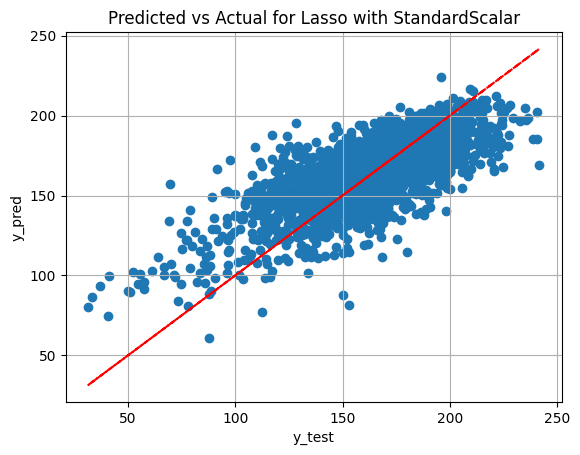

In [14]:
plot_predictions(y_testNP, y_predST, "Lasso with StandardScalar")

## Train linear regression model

0.5362833320241878
0.12746572632611963


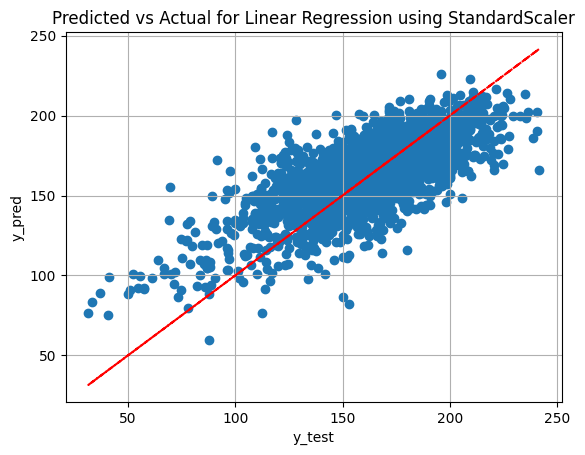

In [15]:
linearST = LinearRegression()
linearST.fit(X_trainST, y_trainNP)

y_predLR = linearST.predict(X_testST)

r2LR = r2_score(y_testNP, y_predLR)
print(r2LR)
print(relative_root_mean_squared_error(y_testNP, y_predLR))

plot_predictions(y_testNP, y_predLR, "Linear Regression using StandardScaler")

## Min/Max scaling

In [16]:
scalerXMM = MinMaxScaler().fit(X_train)
scaleryMM = MinMaxScaler().fit(y_train)

X_trainMM = scalerXMM.transform(X_train)
y_trainMM = scaleryMM.transform(y_train)
X_testMM = scalerXMM.transform(X_test)
y_testMM = scaleryMM.transform(y_test)

## Linear regression with min/max scaling

0.1274846531667526
0.5362532228640937


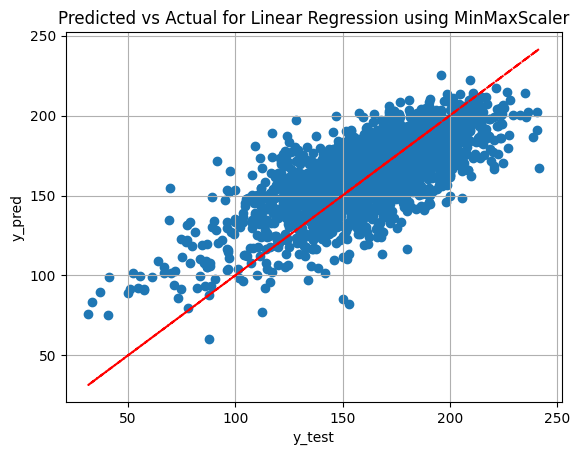

In [17]:
linearMM = LinearRegression()

linearMM.fit(X_trainMM, y_trainNP)

y_predMM = linearMM.predict(X_testMM)

rmseMM = relative_root_mean_squared_error(y_testNP, y_predMM)
r2MM = r2_score(y_testNP, y_predMM)
print(rmseMM)
print(r2MM)

plot_predictions(y_testNP, y_predMM, "Linear Regression using MinMaxScaler")

10.604628635152748
0.7330376225447897


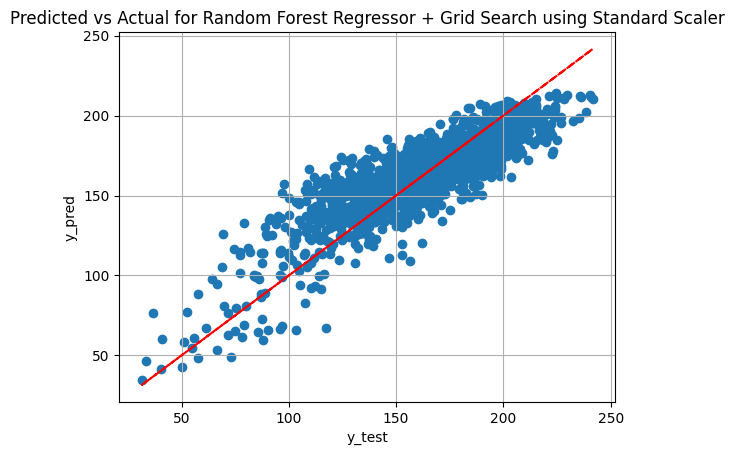

In [18]:
n_estimators = [10, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
param_grid = {
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split, 
    "n_estimators": n_estimators
}

regrRF = RandomForestRegressor()

gsh = HalvingGridSearchCV(
    estimator=regrRF, param_grid=param_grid, cv=5
)
gsh.fit(X_trainST, y_trainNP.ravel())

y_predRFGS = gsh.predict(X_testST)
rmseRFGS = relative_root_mean_squared_error(y_testNP, y_predRFGS)
r2RFGS = r2_score(y_testNP, y_predRFGS)
print(rmseRFGS)
print(r2RFGS)

plot_predictions(y_testNP, y_predRFGS, "Random Forest Regressor + Grid Search using Standard Scaler")

11.359456074524322
0.7922191878049006


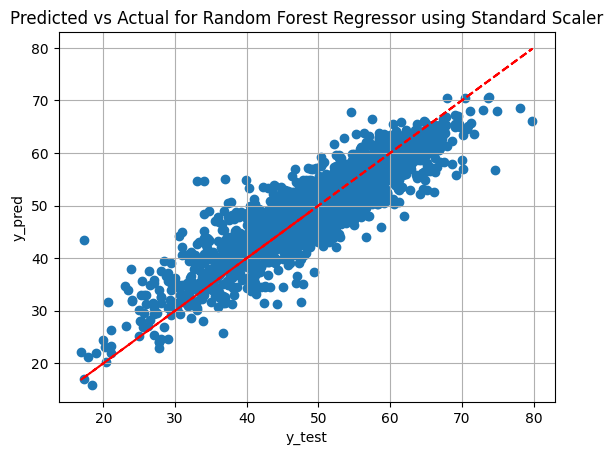

In [81]:
regrRF = RandomForestRegressor()

regrRF.fit(X_trainST, y_trainNP.ravel())

y_predRF = regrRF.predict(X_testST)
rmseRF = relative_root_mean_squared_error(y_testNP, y_predRF)
r2RF = r2_score(y_testNP, y_predRF)
print(rmseRF)
print(r2RF)

plot_predictions(y_testNP, y_predRF, "Random Forest Regressor using Standard Scaler")

0.5002613563830692
0.7568371139463831


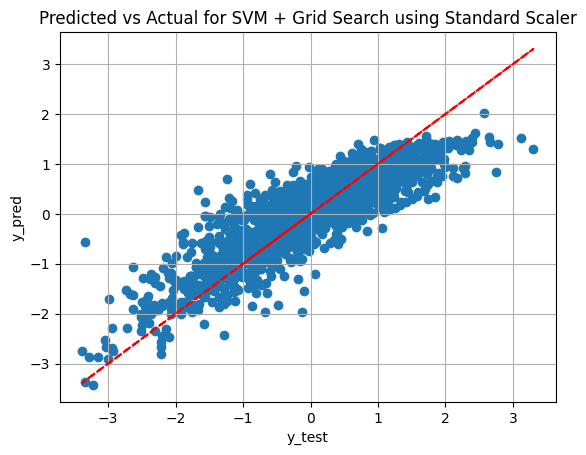

In [58]:
param_grid = {'kernel': ('linear', 'rbf'), 'C': [1, 10, 100]}

regrSVM = svm.SVR()

gshSVM = HalvingGridSearchCV(
    estimator=regrSVM, param_grid=param_grid, cv=5
)
gshSVM.fit(X_trainST, y_trainNP.ravel())

y_predSVMGS = gshSVM.predict(X_testST)
rmseSVMGS = relative_root_mean_squared_error(y_testNP, y_predSVMGS)
r2SVMGS = r2_score(y_testNP, y_predSVMGS)
print(rmseSVMGS)
print(r2SVMGS)

plot_predictions(y_testNP, y_predSVMGS, "SVM + Grid Search using Standard Scaler")

10.629135160686266
0.6921983104780212


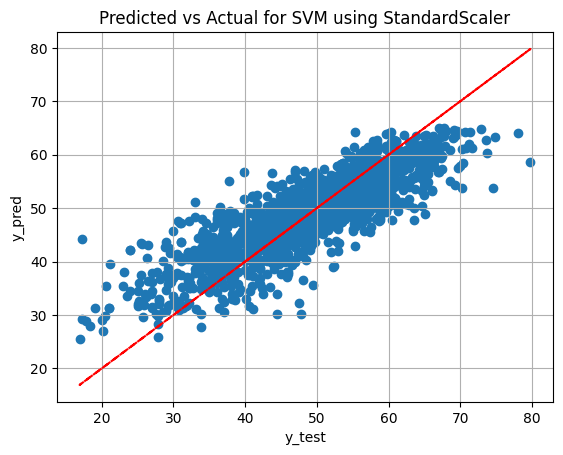

In [85]:
regrSVM = svm.SVR()
regrSVM.fit(X_trainST, y_trainNP.ravel())

y_predSVM = regrSVM.predict(X_testST)

rmseSVM = relative_root_mean_squared_error(y_testNP, y_predSVM)
print(rmseSVM)
r2SVM = r2_score(y_testNP, y_predSVM)
print(r2SVM)

plot_predictions(y_testNP, y_predSVM, "SVM using StandardScaler")

0.09953444697551021
0.7324664432818762


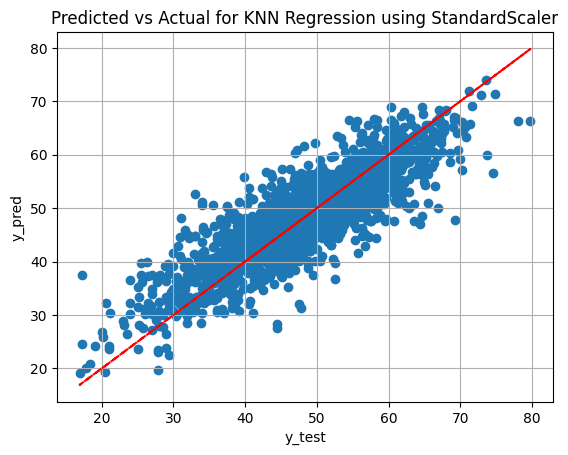

In [84]:
regrKNN = neighbors.KNeighborsRegressor(5, weights="uniform")
regrKNN.fit(X_trainST, y_trainNP)

y_predKNN = regrKNN.predict(X_testST)

rmseKNN = relative_root_mean_squared_error(y_testNP, y_predKNN)
print(rmseKNN)
r2KNN = r2_score(y_testNP, y_predKNN)
print(r2KNN)

plot_predictions(y_testNP, y_predKNN, "KNN Regression using StandardScaler")

5.223469041198794
0.7005708075429784


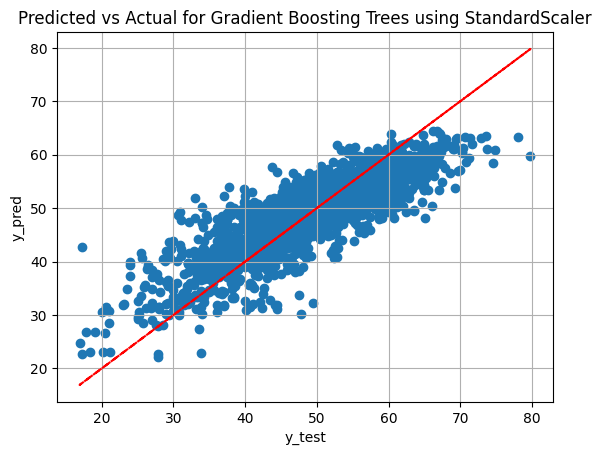

In [86]:
regrGBT = GradientBoostingRegressor()
regrGBT.fit(X_trainST, y_trainNP.ravel())

y_predGBT = regrGBT.predict(X_testST)

rmseGBT = math.sqrt(mean_squared_error(y_testNP, y_predGBT))
print(rmseGBT)
r2GBT = r2_score(y_testNP, y_predGBT)
print(r2GBT)

plot_predictions(y_testNP, y_predGBT, "Gradient Boosting Trees using StandardScaler")

0.1312673867956071
0.5615706540831711


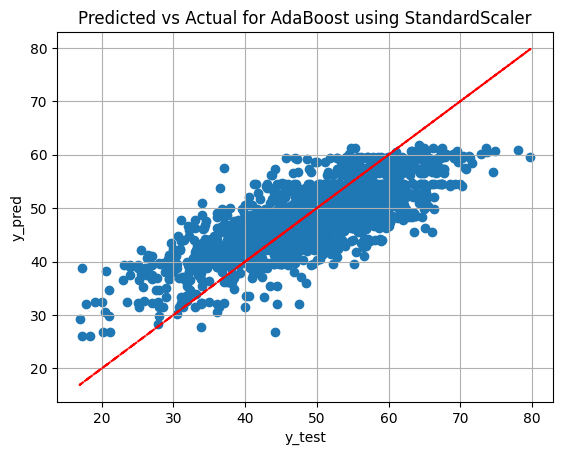

In [64]:
regrAda = AdaBoostRegressor()
regrAda.fit(X_trainST, y_train["yield"].ravel())

y_predAda = regrAda.predict(X_testST)

rmseAda = relative_root_mean_squared_error(y_test["yield"].values, y_predAda)
print(rmseAda)
r2Ada = r2_score(y_test["yield"], y_predAda)
print(r2Ada)

plot_predictions(y_test, y_predAda, "AdaBoost using StandardScaler")

In [87]:
min_features_to_select = 20  # Minimum number of features to consider
clf = LinearRegression()

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=5,
    scoring='r2',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_trainST, y_trainNP)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 66


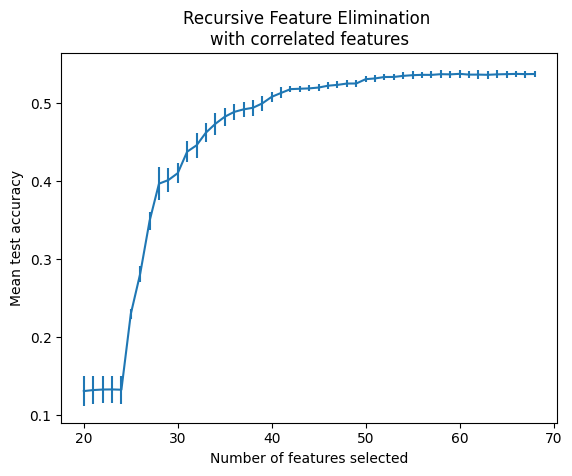

In [70]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [37]:
def plot_rfe(rfecv, min_features_to_select):
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    plt.show()

def test_model(X_train, y_train, X_test, y_test, min_features_to_select, model=LinearRegression()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        min_features_to_select = min_features_to_select
        clf = model

        if type(model).__name__ == "HalvingGridSearchCV":
            importance_getter = "best_estimator_.feature_importances_"
        else:
            importance_getter = "auto"

        rfecv = RFECV(
            estimator=clf,
            step=1,
            cv=5,
            scoring='r2',
            min_features_to_select=min_features_to_select,
            importance_getter=importance_getter,
        )
        rfecv.fit(X_train, y_train)

        print(f"Optimal number of features: {rfecv.n_features_}")

        y_pred = rfecv.predict(X_test)

        rrmse = relative_root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"RRMSE: {rrmse}")
        print(f"R-squared: {r2}")

        plot_rfe(rfecv, min_features_to_select)
        plot_predictions(y_test, y_pred, type(model).__name__)

Works with: LinearRegression, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

Optimal number of features: 66
RRMSE: 0.131290137092844
R-squared: 0.540185293263215


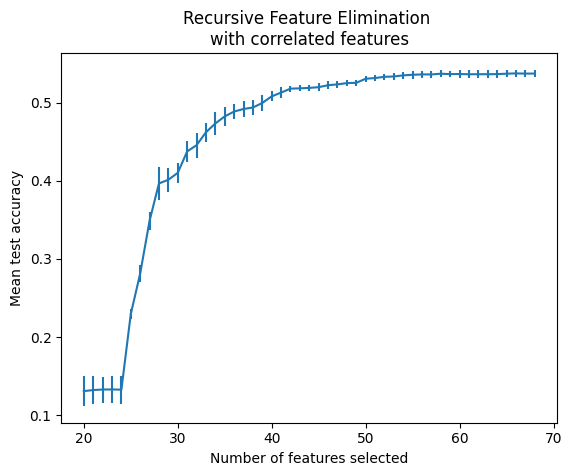

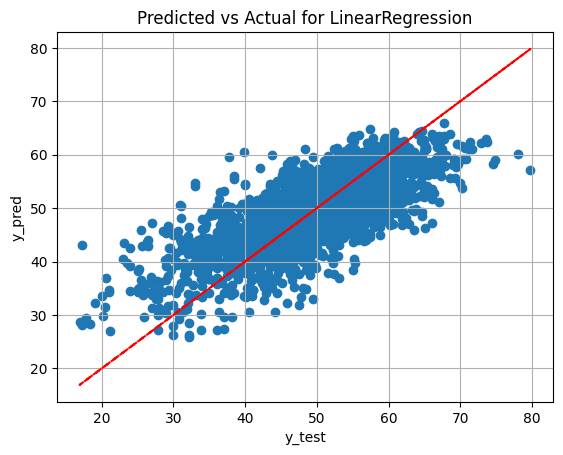

In [88]:
test_model(X_trainST, y_trainNP, X_testST, y_testNP, 20, model=LinearRegression())

Optimal number of features: 67
RRMSE: 10.505087816393125
R-squared: 0.5662366839837107


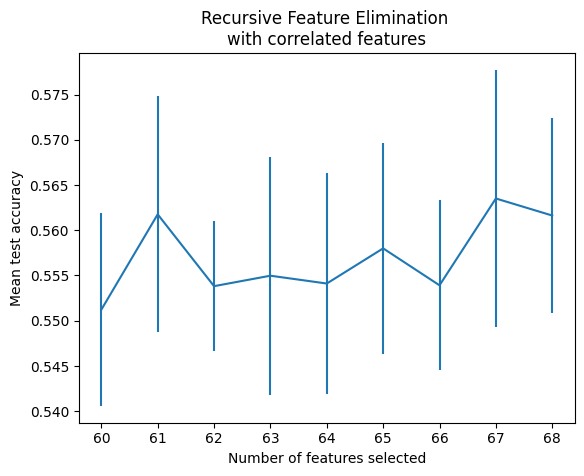

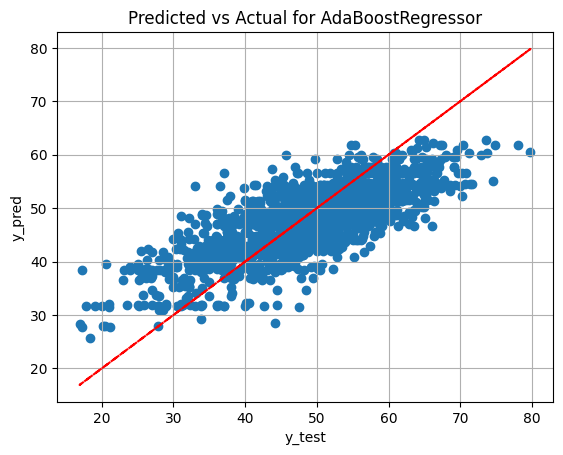

In [89]:
test_model(X_trainST, y_trainNP, X_testST, y_testNP, 60, model=AdaBoostRegressor())

In [18]:
n_estimators = [10, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
param_grid = {
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split, 
    "n_estimators": n_estimators
}

regrRF_RFE = RandomForestRegressor()

gsh_RF_RFE = HalvingGridSearchCV(
    estimator=regrRF_RFE, param_grid=param_grid, cv=5
)

test_model(X_trainST, y_trainNP, X_testST, y_testNP, 20, model=gsh_RF_RFE)

KeyboardInterrupt: 